In [1]:
import stylised_facts.stylised_facts_data_utilities.createLOB as createLOB
import stylised_facts.stylised_facts_data_utilities.gpyNARX as gpyNARX

In [2]:
from __future__ import print_function
import GPy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

In [3]:
nSamples = 140
X1 = np.random.rand(nSamples, 1)*8*np.pi
X1.sort(0)
Y1 = np.sin(X1) + np.random.randn(*X1.shape)*0.002

U1 = np.sin(X1) + np.random.randn(*X1.shape)*0.02
U1 = Y1**2-2*Y1+5+np.random.randn(*Y1.shape)*0.005

In [4]:
data = pd.DataFrame( np.concatenate( [X1, Y1, U1], axis= 1), columns =['X', 'Y', 'U'])

In [5]:
timeWindow = 10
data = data.merge(pd.concat([data.shift(lag).rename(columns = lambda c: 'lagged_{}_{}'.format(c , lag) ) for lag in range(1, timeWindow+1 )],axis=1), right_index=True, left_index=True, how='left')
data = data.dropna()

In [7]:
laggedYColumns = [c for c in data.columns if 'lagged_Y' in c]
laggedUColumns = [c for c in data.columns if 'lagged_U' in c]
inputColumns = laggedYColumns + laggedUColumns
outputColumn ='Y'
###
dataSize= data.shape[0]
trainDataSize = 50
testDataSize = dataSize - trainDataSize
##
trainData = data.iloc[:trainDataSize]
testData = data.iloc[:testDataSize]

In [8]:

# # Train regression model
# num_inducing = 40
# m = GPy.models.SparseGPRegression(trainData[inputColumns].values, trainData[outputColumn].values, num_inducing = num_inducing)
# # m.optimize('bfgs', max_iters=1000, messages=True)
# # print(m)

In [9]:

import gpflow
import numpy as np

import matplotlib.pyplot as plt
import tensorflow as tf

import gpflow
from gpflow.utilities import ops, print_summary
from gpflow.config import set_default_float, default_float, set_default_summary_fmt
from gpflow.ci_utils import ci_niter

set_default_float(np.float64)
set_default_summary_fmt("notebook")

%matplotlib inline

In [10]:
from gpflow.kernels import RBF


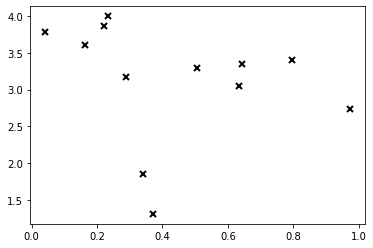

In [11]:
N = 12
X = np.random.rand(N,1)
Y = np.sin(12*X) + 0.66*np.cos(25*X) + np.random.randn(N,1)*0.1 + 3
plt.plot(X, Y, 'kx', mew=2)

In [12]:
k = gpflow.kernels.Matern52(1, lengthscales=0.3)


In [13]:
num_inducing = 40

# Create toy data
N1 = 140
X1 = np.random.rand(N1, 1) * 8*np.pi
X1.sort(0)
Y1 = np.sin(X1) + np.random.randn(*X1.shape) * 0.02

{'inducing': <matplotlib.collections.PathCollection at 0x7fa5dc57a6d8>,
 'dataplot': [<matplotlib.collections.PathCollection at 0x7fa5e6e8b160>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x7fa5dc57a9e8>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x7fa5dc57ae80>]}

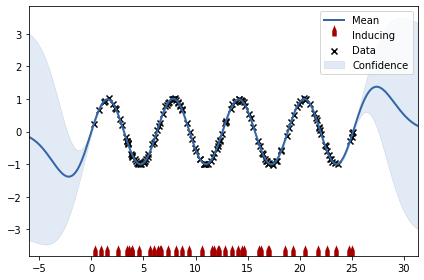

In [16]:
# Train a standard model
m1 = GPy.models.SparseGPRegression(X1,Y1, num_inducing = num_inducing)
m1.optimize('bfgs', max_iters=100)
m1.plot()


In [18]:

# Create transformed data (autoregressive dataset)
ws=10 # Windowsize
xx,yy = gpyNARX.transformTimeSeriesToSeq(Y1, ws)

#uu,tmp = transformTimeSeriesToSeq(U1, ws)
# Test the above: np.sin(uu) - xx

#uu = yy**2 -2*yy + 5 + np.random.randn(*yy.shape) * 0.005
U1 = Y1**2 -2*Y1 + 5 + np.random.randn(*Y1.shape) * 0.005
uu,tmp = gpyNARX.transformTimeSeriesToSeq(U1, ws)

In [19]:

Xtr = xx[0:50,:]
Xts = xx[50:,:]
Ytr = yy[0:50,:]
Yts = yy[50:,:]
Utr = uu[0:50,:]
Uts = uu[50:,:]


Name : sparse_gp
Objective : -16.394540765830243
Number of Parameters : 803
Number of Optimization Parameters : 803
Updates : True
Parameters:
  sparse_gp.               |                 value  |  constraints  |  priors
  inducing_inputs          |              (40, 20)  |               |        
  rbf.variance             |    18.145555547156984  |      +ve      |        
  rbf.lengthscale          |    14.805475784901526  |      +ve      |        
  Gaussian_noise.variance  |  0.006602529164935622  |      +ve      |        


Text(0.5, 1.0, 'NARX-full')

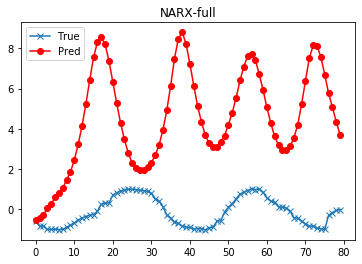

In [22]:
# Train regression model
m = GPy.models.SparseGPRegression(np.hstack((Xtr,Utr)),Ytr, num_inducing = num_inducing)
m.optimize('bfgs', max_iters=1000, messages=True)
print(m)

# Initial window to kick-off free simulation
x_start = Xts[0,:][:,None].T

# Free simulation
ygp, varygp = gpyNARX.gp_narx(m, x_start, Yts.shape[0], Uts, ws)
plt.figure()
plt.plot(Yts, 'x-')
plt.plot(ygp, 'ro-')
plt.legend(('True','Pred'))
plt.title('NARX-full')


In [24]:

Xrand = np.random.randn(*Xtr.shape)
mrandx = GPy.models.SparseGPRegression(np.hstack((Xrand,Utr)),Ytr, num_inducing = num_inducing)
mrandx.optimize('bfgs', max_iters=1000, messages=True)
print(mrandx)

# Free simulation
ygp, varygp = gpyNARX.gp_narx(mrandx, x_start, Yts.shape[0], Uts, ws)
pb.figure()
pb.plot(Yts, 'x-')
pb.plot(ygp, 'ro-')
pb.legend(('True','Pred'))
pb.title('NARX-RAND_X')


Urand = np.random.randn(*Utr.shape)
mrandu = GPy.models.SparseGPRegression(np.hstack((Xtr,Urand)),Ytr, num_inducing = num_inducing)
mrandu.optimize('bfgs', max_iters=1000, messages=True)
print(mrandu)

# Free simulation
ygp, varygp = gpyNARX.gp_narx(mrandu, x_start, Yts.shape[0], Uts, ws)
pb.figure()
pb.plot(Yts, 'x-')
pb.plot(ygp, 'ro-')
pb.legend(('True','Pred'))
pb.title('NARX-RAND_U')


mrandxu = GPy.models.SparseGPRegression(np.hstack((Xrand,Urand)),Ytr, num_inducing = num_inducing)
mrandxu.optimize('bfgs', max_iters=1000, messages=True)
print(mrandxu)

# Free simulation
ygp, varygp = gp_narx(mrandxu, x_start, Yts.shape[0], Uts, ws)
plt.figure()
plt.plot(Yts, 'x-')
plt.plot(ygp, 'ro-')
plt.legend(('True','Pred'))
plt.title('NARX-RAND_X_U')


Name : sparse_gp
Objective : 18.208480614227256
Number of Parameters : 803
Number of Optimization Parameters : 803
Updates : True
Parameters:
  sparse_gp.               |                 value  |  constraints  |  priors
  inducing_inputs          |              (40, 20)  |               |        
  rbf.variance             |    2.0624813162096154  |      +ve      |        
  rbf.lengthscale          |    15.064329691910219  |      +ve      |        
  Gaussian_noise.variance  |  0.048586414574055915  |      +ve      |        


NameError: name 'pb' is not defined